In [13]:
from sklearn.decomposition import PCA
import splitfolders
import zipfile,os
import numpy as np
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from pytictoc import TicToc
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [2]:
local_zip = 'img.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

base_dir ='img'


In [3]:
splitfolders.ratio(base_dir, output=base_dir, ratio=(0.7,0.3))
 
train = os.path.join(base_dir, 'train')
val = os.path.join(base_dir, 'val')

Copying files: 420 files [00:07, 58.76 files/s]


In [4]:
os.listdir('img/train')
os.listdir('img/val')

['AAA',
 'ABI',
 'AFI',
 'AGH',
 'AIL',
 'ARL',
 'ASA',
 'BDL',
 'DIA',
 'DIO',
 'DRA',
 'EZA',
 'FAR',
 'FMR',
 'FRS',
 'GLA',
 'GPS',
 'HMA',
 'HZR',
 'IDR',
 'KDA',
 'MAA',
 'MAJ',
 'MFA',
 'MFH',
 'MGN',
 'MMF',
 'MRF',
 'MSA',
 'MZA',
 'MZB',
 'NIS',
 'QTH',
 'RCK',
 'RKS',
 'SHE',
 'SNN',
 'SVD',
 'SYH',
 'SYN',
 'train',
 'val',
 'YSS',
 'ZHT']

### Pre-Processing

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                rescale = 1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                rescale = 1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode = 'nearest')

In [6]:
train_generator = train_datagen.flow_from_directory(
        train,
        batch_size = 1,
        color_mode = 'grayscale',
        shuffle = False,
        class_mode = "categorical",
        target_size =  (100, 100))

test_generator = test_datagen.flow_from_directory(
        val,
        batch_size = 1,
        color_mode = 'grayscale',
        shuffle = False,
        class_mode = "categorical",
        target_size =  (100, 100))

Found 294 images belonging to 44 classes.
Found 126 images belonging to 44 classes.


### BPNN

In [15]:
X_train = train_generator[0][0][0].flatten()
for i in range(1, len(train_generator)):
    features = train_generator[i][0][0].flatten()
    X_train = np.vstack((X_train, features))

X_test = test_generator[0][0][0].flatten()
for i in range(1, len(test_generator)):
    features = test_generator[i][0][0].flatten()
    X_test = np.vstack((X_test, features))
    

In [16]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
Y_train = np.array(train_generator.labels)
Y_test = np.array(test_generator.labels)

In [17]:
pca=PCA()
pca.fit(X_train_scaled)
pca=PCA(n_components=100, whiten=True)
X_pca_train = pca.fit_transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)
pca_std = np.std(X_pca_train)

In [22]:
clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(100,),
                    batch_size=1,
                    learning_rate_init=0.003,
                    momentum=0.7,activation='relu',
                    alpha=0.01,shuffle=False,
                    random_state=2)
clf.fit(X_pca_train,Y_train)

C:\Users\dimas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.01, batch_size=1, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.003, max_fun=15000, max_iter=200,
              momentum=0.7, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2, shuffle=False, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [23]:
start = timer()
N_TRAIN_SAMPLES = X_pca_train.shape[0]
N_EPOCHS = 100
N_BATCH = 128
N_CLASSES = np.unique(Y_train)

scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    print('epoch: ', epoch)
    # SHUFFLING
    random_perm = np.random.permutation(X_train.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        clf.partial_fit(X_pca_train[indices], Y_train[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(clf.score(X_pca_train, Y_train))

    # SCORE TEST
    scores_test.append(clf.score(X_pca_test, Y_test))

    epoch += 1

end = timer()

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

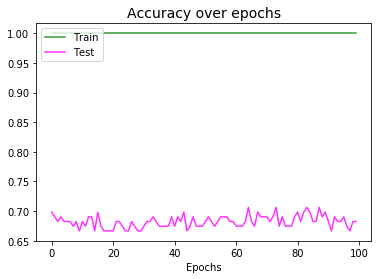

In [24]:
plt.plot(scores_train, color='green', alpha=0.8, label='Train')
plt.plot(scores_test, color='magenta', alpha=0.8, label='Test')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

In [27]:
train_pred_bpnn = clf.predict(X_pca_train)

train_acc_bpnn = accuracy_score(Y_train, train_pred_bpnn)

print(f'Training Accuracy: {train_acc_bpnn * 100}%')

test_pred_bpnn = clf.predict(X_pca_test)

test_acc_bpnn = accuracy_score(Y_test, test_pred_bpnn)

print(f'Testing Accuracy: {test_acc_bpnn * 100}%')

Training Accuracy: 100.0%
Testing Accuracy: 68.25396825396825%


In [25]:
print(end - start)

39.55232700000002


In [31]:
import pandas as pd
result = pd.DataFrame(
    [scores_train,scores_test],
    index=["accuracy","val_accuracy"],
    columns=[f'epoch_{num + 1}' for num in range(100)])

result

,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,epoch_9,epoch_10,...,epoch_91,epoch_92,epoch_93,epoch_94,epoch_95,epoch_96,epoch_97,epoch_98,epoch_99,epoch_100
accuracy,1.000000,1.000000,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000,1.00000,1.000000,...,1.00000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.00000,1.00000
val_accuracy,0.698413,0.690476,0.68254,0.690476,0.68254,0.68254,0.68254,0.674603,0.68254,0.666667,...,0.68254,0.666667,0.690476,0.68254,0.68254,0.690476,0.674603,0.666667,0.68254,0.68254
